In [1]:
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Путь до папки с данными
os.chdir('/Users/tony/Desktop/Pracs ML EF/KNN/Данные для практической работы №1 ')

In [6]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [7]:
# Фиксируем random_seed 
SEED = 42

In [8]:
# Загружаем данные
data = pd.read_csv('train_data.csv')
ans = pd.read_csv('train_ans.csv')
data.shape, ans.shape

((5574703, 3), (57711, 2))

In [9]:
# Разделим данные на обучение и валидацию
np.random.seed(SEED)
all_unq_users = np.unique(data.user)
train_users, test_users = np.split(
    np.random.permutation(all_unq_users), [int(len(all_unq_users) * 0.7)]
)

train_data = data.loc[
    (data.user.isin(set(train_users)))
].sort_values(['user', 'day'])
train_ans = ans.loc[(ans.user.isin(set(train_users))), ['user', 'sum']]

test_data = data.loc[
    (data.user.isin(set(test_users)))
].sort_values(['user', 'day'])
test_ans = ans.loc[(ans.user.isin(set(test_users))), ['user', 'sum']]


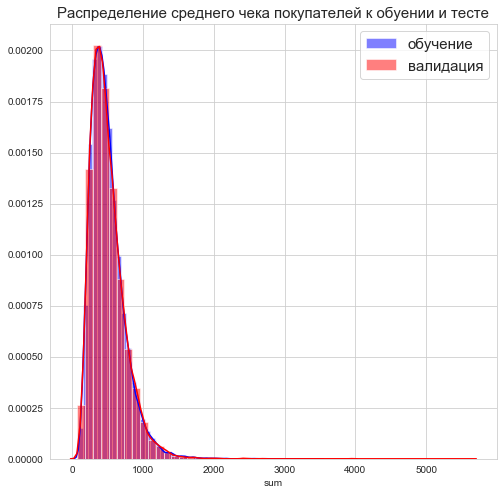

In [10]:
# Проверим, что разделение на обучение и валидацию случайное с точки зрения среднего чека пользователя
plt.title(f'Распределение среднего чека покупателей к обуении и тесте', fontsize=15);
sns.distplot(train_data.groupby(['user'])['sum'].mean(), color='blue', label='обучение', hist_kws={'alpha': 0.5});
sns.distplot(test_data.groupby(['user'])['sum'].mean(), color='red', label='валидация', hist_kws={'alpha': 0.5});
plt.legend(fontsize=15);

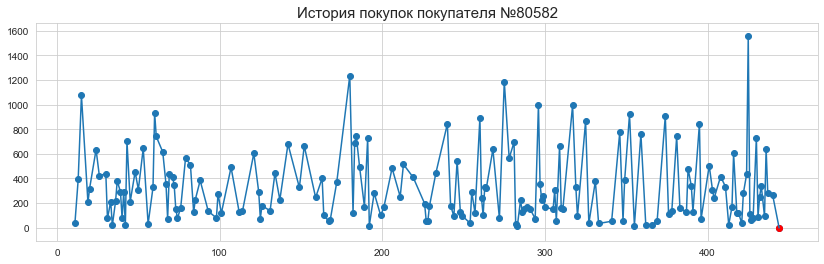

In [9]:
# Изобразим историю сумм покупок для какого-то покупателя
np.random.seed(SEED)
some_user = np.random.choice(all_unq_users)

tmp_df = data.loc[
    (data['user'] == some_user)
].sort_values(['day'])

plt.figure(figsize=(14, 4))
plt.title(f'История покупок покупателя №{some_user}', fontsize=15);
plt.plot(tmp_df['day'], tmp_df['sum']);
plt.scatter(tmp_df['day'], tmp_df['sum']);
plt.scatter([tmp_df.values[-1, -2]], [tmp_df.values[-1, -1]], color='red');


In [10]:
# Реализуем функцию подсчёта мейпа (MAPE)
def mape(y_true: np.array, y_pred: np.array) -> float:
    
    """
    Подсчитывает MAPE по формуле: (1/n) * ∑ |y_true - y_pred| / |y_true|
    
    Args:
        y_true: np.array с истинными значениями таргета
        y_pred: np.array с предсказанными значениями
    Returns:
        MAPE (если в y_true есть нули, то такие наблюдения нужно выкинуть из рассчёта метрики)
    """
    
    nonzero_true = [val for val in y_true if val != 0]
    nonzero_pred = [val for val in y_pred if val != 0]
    
    return (1 / len(nonzero_true)) * sum([abs(i - j) / abs(i) for i, j in zip(nonzero_true, nonzero_pred)])

In [11]:
# Сделаем прогноз как среднюю стоимость покупки на истории и посчитаем его точность (MAPE)
tmp_df = data.loc[(data['sum'] != -1)].groupby(['user'])['sum'].mean().reset_index()\
            .rename(columns={'sum': 'mean_historical_sum'})
ans = (ans.merge(tmp_df, on=['user'], how='inner'))

In [12]:
# Посчитаем точность такого прогноза (MAPE)
print("MAPE:", round(mape(y_true=ans['sum'].values, y_pred=ans['mean_historical_sum'].values), 4))

MAPE: 2.0529


In [15]:
%%time
# Создадим удобное представление истории продаж
def prepare_X(df: pd.DataFrame, ans: pd.DataFrame=None) -> pd.DataFrame:
    
    """
    Преобразует данные об истории продаж в удобный для модели формат. 
    Обязательно наличие у df колонок "user", "day" и "sum"
    
    Args:
        df - датафрейм с историей продаж
        ans - датафрейм с таргетами (обязательны колонки "user" и "sum")
    """
    
    tmp_df = (
        df
        .sort_values(by=['user', 'day'], ascending=[True, False])
        .groupby(['user'])
        ['day', 'sum']
        .apply(
            lambda x: [list(x['day']), list(x['sum'])]
        )
        .apply(pd.Series)
        .rename(columns={0: 'day', 1: 'sum'})
        .reset_index()
    )
    tmp2 = pd.DataFrame(tmp_df['day'].to_list(), columns=[f'day{i}' for i in range(tmp_df['day'].agg(len).max())])
    tmp3 = pd.DataFrame(tmp_df['sum'].to_list(), columns=[f'sum{i}' for i in range(tmp_df['day'].agg(len).max())])
    Xy = pd.concat([tmp_df[['user']], tmp2, tmp3], axis=1).reset_index(drop=True)
    
    if ans is not None:
        Xy = (Xy.merge(ans[['user', 'sum']], on=['user'], how='left')).rename(columns={'sum': 'target'})
    
    return Xy

Xy = prepare_X(df=data, ans=ans)

CPU times: user 36.3 s, sys: 3.45 s, total: 39.8 s
Wall time: 47.9 s


In [17]:
# Посмотрим, какой вид получился
N = 5
Xy[['user'] + [f'day{i}' for i in range(N)] + ['target'] + [f'sum{i}' for i in range(1, N+1)]].head()

,user,day0,day1,day2,day3,day4,target,sum1,sum2,sum3,sum4,sum5
0,1,438,437,433,432,430,20,555,3,40,763,650
1,2,439,437,435,426,424,66,50,682,88,26,382
2,4,439,434,432,425,420,822,854,174,734,550,1635
3,5,432,429,426,423,421,138,275,260,151,43,114
4,7,434,425,421,418,411,689,838,50,748,799,433


In [26]:
n_neighbours = []
mapes_train = []
mapes_test = []

for k in tqdm(range(1, 60+1)):
    k_mean = pd.concat([Xy[['user']], Xy[[f'sum{i}' for i in range(1, k+1)]].mean(axis=1)], axis=1)
    k_mean.rename(columns={0: f'{k}_mean'}, inplace=True)

    tmp = (
        ans
        .merge(
            k_mean, 
            on=['user'],
            how='left'
        )
    )
    n_neighbours.append(k)
    mapes_train.append(mape(y_true=tmp['sum'][(tmp.user.isin(set(train_users)))], 
                            y_pred=tmp[f'{k}_mean'][(tmp.user.isin(set(train_users)))]));
    mapes_test.append(mape(y_true=tmp['sum'][(tmp.user.isin(set(train_users)))], 
                           y_pred=tmp[f'{k}_mean'][(tmp.user.isin(set(train_users)))]));
n_neighbours = np.array(n_neighbours)
mapes_train = np.array(mapes_train)
mapes_test = np.array(mapes_test)

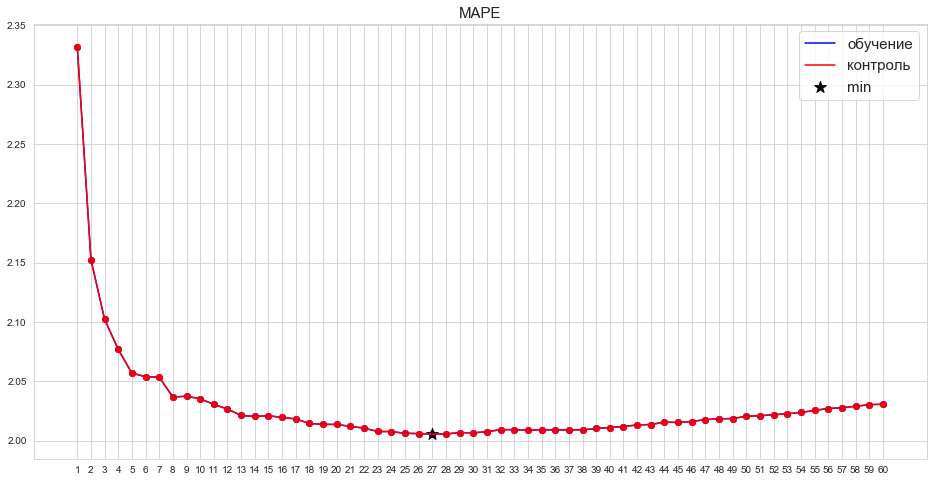

In [28]:
plt.figure(figsize=(16, 8))
plt.title(f'MAPE', fontsize=15);
plt.plot(n_neighbours, mapes_train, color='blue', label='обучение');
plt.scatter(n_neighbours, mapes_train, color='blue');

plt.plot(n_neighbours, mapes_test, color='red', label='контроль');
plt.scatter(n_neighbours, mapes_test, color='red');

k_neighbours = n_neighbours[np.argmin(mapes_test)] # оптимальное число соседей

plt.scatter([k_neighbours], [np.min(mapes_test)], marker='*', s=150, 
            color='black', label='min');

plt.legend(fontsize=15);
plt.xticks(n_neighbours);

### Весовые схемы

Реализуем различные весовые схемы:

1) $\tilde{w_{i}} = \left( \frac{d - i + 1}{d}  \right)^\delta, \ i \in \{1, 2, \dots, d   \}, \ \delta \in [0, +\infty)$

2) $\tilde{w_{i}} = \lambda^i, \ \lambda \in (0, 1]$

3) $\tilde{w_{i}} = \frac{1}{i^\gamma}, \ \gamma \in [0, +\infty)$

Итоговые веса должны быть нормированы: $\sum\limits_{i=1}^d w_{i} = 1$. Для этого просто поделим веса на сумму: $w_{i} = \frac{\tilde{w_{i}}}{\sum\limits_{i=1}^d\tilde{w_{i}}}$

In [29]:
def delta_weights(d: int, delta: float=1.0) -> np.array:
    weights = np.array([((d - i + 1) / d) ** delta for i in range(1, d+1)])
    return weights / np.sum(weights)

def lamb_weights(d: int, lamb: float=1) -> np.array:
    weights = np.array([lamb ** i for i in range(1, d+1)])
    return weights / np.sum(weights)

def gamma_weights(d: int, gamma: float=1) -> np.array:
    weights = np.array([(1 / i**gamma) for i in range(1, d+1)])
    return weights / np.sum(weights)

In [30]:
delta_list = []
mapes_train = []
mapes_test = []
for delta in tqdm(np.logspace(-5, 2, 50)):    
    predictions = Xy[['user']].copy()
    weights = delta_weights(d=k_neighbours, delta=delta)
    predictions['predictions'] = (Xy[[f'sum{i}' for i in range(1, k_neighbours+1)]] @ weights)
    
    tmp_df = (
        ans
        .merge(
            predictions,
            on=['user'],
            how='left'
        )
    )
    tmp_df.dropna(inplace=True)
    delta_list.append(delta)
    mape_ = mape(y_true=tmp_df['sum'][(tmp['user'].isin(set(train_users)))].values, 
                y_pred=tmp_df['predictions'][(tmp['user'].isin(set(train_users)))].values)
    mapes_train.append(mape_)
    
    mape_ = mape(y_true=tmp_df['sum'][(tmp['user'].isin(set(test_users)))].values, 
                y_pred=tmp_df['predictions'][(tmp['user'].isin(set(test_users)))].values)
    mapes_test.append(mape_)
    
delta_list = np.array(delta_list)
mapes_train = np.array(mapes_train);
mapes_test = np.array(mapes_test);

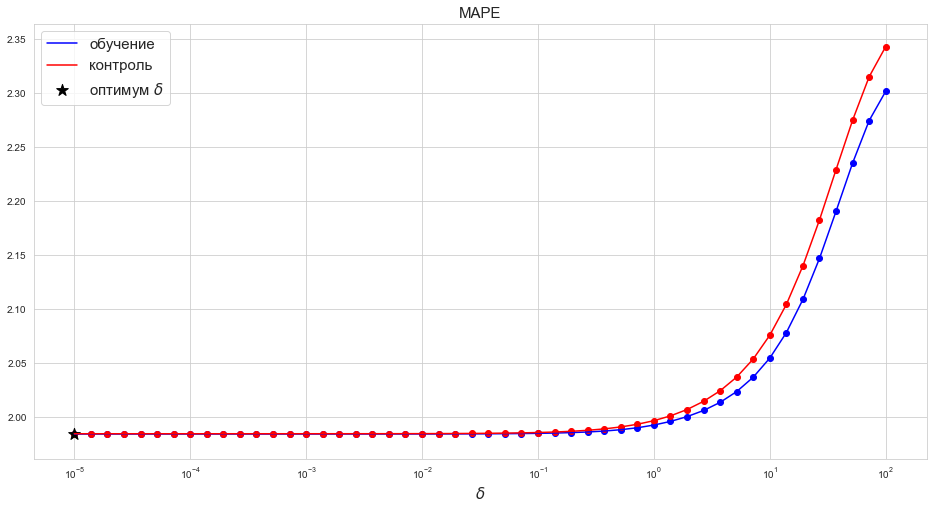

In [31]:
plt.figure(figsize=(16, 8))
plt.title(f'MAPE', fontsize=15);
plt.plot(delta_list, mapes_train, color='blue', label='обучение');
plt.scatter(delta_list, mapes_train, color='blue');
plt.plot(delta_list, mapes_test, color='red', label='контроль');
plt.scatter(delta_list, mapes_test, color='red');

delta_opt = delta_list[np.argmin(mapes_train)]
plt.scatter([delta_opt], [np.min(mapes_train)], s=150, marker='*', color='black', label=r'оптимум $\delta$')

plt.xscale('log')
plt.legend(fontsize=15);
plt.xlabel(f'$\delta$', fontsize=15);

In [32]:
lamba_list = []
mapes_train = []
mapes_test = []
for lamb in tqdm(np.linspace(1e-5, 1, 50)):    
    predictions = Xy[['user']].copy()
    weights = lamb_weights(d=k_neighbours, lamb=lamb)
    predictions['predictions'] = (Xy[[f'sum{i}' for i in range(1, k_neighbours+1)]] @ weights)
    
    tmp_df = (
        ans
        .merge(
            predictions,
            on=['user'],
            how='left'
        )
    )
    tmp_df.dropna(inplace=True)
    lamba_list.append(lamb)
    mape_ = mape(y_true=tmp_df['sum'][(tmp['user'].isin(set(train_users)))].values, 
                y_pred=tmp_df['predictions'][(tmp['user'].isin(set(train_users)))].values)
    mapes_train.append(mape_)
    
    mape_ = mape(y_true=tmp_df['sum'][(tmp['user'].isin(set(test_users)))].values, 
                y_pred=tmp_df['predictions'][(tmp['user'].isin(set(test_users)))].values)
    mapes_test.append(mape_)
    
lamba_list = np.array(lamba_list)
mapes_train = np.array(mapes_train);
mapes_test = np.array(mapes_test);

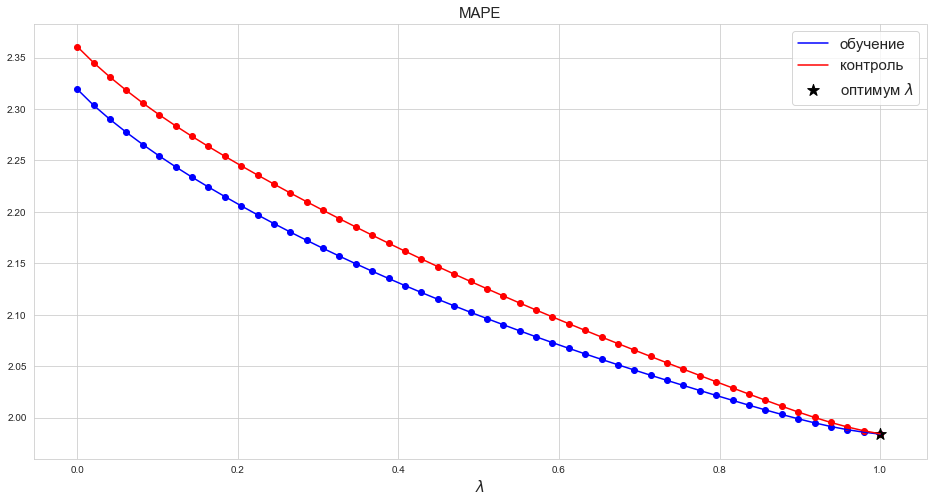

In [33]:
plt.figure(figsize=(16, 8))
plt.title(f'MAPE', fontsize=15);
plt.plot(lamba_list, mapes_train, color='blue', label='обучение');
plt.scatter(lamba_list, mapes_train, color='blue');
plt.plot(lamba_list, mapes_test, color='red', label='контроль');
plt.scatter(lamba_list, mapes_test, color='red');

lambda_opt = lamba_list[np.argmin(mapes_train)]
plt.scatter([lambda_opt], [np.min(mapes_train)], s=150, marker='*', color='black', label=r'оптимум $\lambda$')


plt.legend(fontsize=15);
plt.xlabel(f'$\lambda$', fontsize=15);

In [34]:
gamma_list = []
mapes_train = []
mapes_test = []
for gamma in tqdm(np.logspace(-5, 10, 60)):    
    predictions = Xy[['user']].copy()
    weights = gamma_weights(d=k_neighbours, gamma=gamma)
    predictions['predictions'] = (Xy[[f'sum{i}' for i in range(1, k_neighbours+1)]] @ weights)
    
    tmp_df = (
        ans
        .merge(
            predictions,
            on=['user'],
            how='left'
        )
    )
    tmp_df.dropna(inplace=True)
    gamma_list.append(gamma)
    mape_ = mape(y_true=tmp_df['sum'][(tmp['user'].isin(set(train_users)))].values, 
                y_pred=tmp_df['predictions'][(tmp['user'].isin(set(train_users)))].values)
    mapes_train.append(mape_)
    
    mape_ = mape(y_true=tmp_df['sum'][(tmp['user'].isin(set(test_users)))].values, 
                y_pred=tmp_df['predictions'][(tmp['user'].isin(set(test_users)))].values)
    mapes_test.append(mape_)
    
gamma_list = np.array(gamma_list)
mapes_train = np.array(mapes_train);
mapes_test = np.array(mapes_test);

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


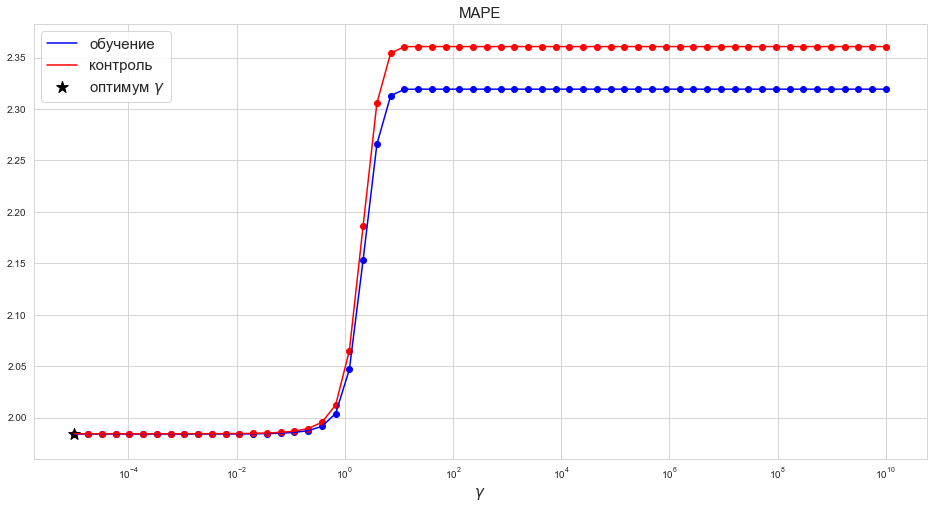

In [35]:
plt.figure(figsize=(16, 8))
plt.title(f'MAPE', fontsize=15);
plt.plot(gamma_list, mapes_train, color='blue', label='обучение');
plt.scatter(gamma_list, mapes_train, color='blue');
plt.plot(gamma_list, mapes_test, color='red', label='контроль');
plt.scatter(gamma_list, mapes_test, color='red');

gamma_opt = gamma_list[np.argmin(mapes_train)]
plt.scatter([gamma_opt], [np.min(mapes_train)], s=150, marker='*', color='black', label=r'оптимум $\gamma$')



plt.xscale('log')
plt.legend(fontsize=15);
plt.xlabel(f'$\gamma$', fontsize=15);

### Получение предсказаний для теста

In [43]:
%%time
# Загружаем данные, для которых хотим получить предсказания
test_data = pd.read_csv('test_data.csv')
# Преобразуем данные
Xy_test = prepare_X(df=test_data)

CPU times: user 14.5 s, sys: 792 ms, total: 15.3 s
Wall time: 14.8 s


In [48]:
# Получаем предскзания
predictions = Xy_test[['user']].reset_index(drop=True).copy()
weights = delta_weights(d=k_neighbours, delta=delta_opt)
predictions['predictions'] = (Xy_test[[f'sum{i}' for i in range(1, k_neighbours+1)]] @ weights)

In [61]:
# Сохранение предсказаний
predictions.to_csv('test_predictions.csv', index=False)